# Notebook steps

1. Fit generative model on validation data
Fit Generative pixel model MNIST on MNIST validation data (exact beta bernoulli model)
2. Assess surprisal of model samples and data samples under this generative view 
Assess surprisal of model samples and data samples under this generative view (conditionally and unconditionally), leading to three surprisal statistics:
    1. Conditional statistic on conditional samples: `conditional_conditional`
    2. Unconditional statistic on conditional samples: `unconditional_conditional`
    3. Unconditional statistic on unconditional samples: `unconditional_unconditional`
3. Fit DP Mixture of truncated normals on surprisal values model groups and data group
4. Assess three different divergence measures to assess the difference between model group surprisal values and data group surprisal values
    1. KL between component assignments under DP Mixture
    2. KL between estimated densities under DP Mixture
    3. Wasserstein distance between surprisal histograms (no DP used)

# Imports

In [1]:
import sys
CODE_DIR = "/home/cbarkhof/fall-2021"
sys.path.append(CODE_DIR)

In [2]:
import os
import torch
import numpy as np
import pandas as pd

%config InlineBackend.figure_format='retina'
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import seaborn as sns; sns.set()

from clean_analysis.dp_mixture_for_surprisals import *
from clean_analysis.utils.analysis_utils import get_n_data_samples_x_y
from clean_analysis.utils.MNIST_preprocessing_steps import make_run_overview_df
from clean_analysis.generative_analysis_models.generative_pixel_model_mnist import GenPixelModelMNIST

# Get some MNIST data

In [3]:
N_DATA_SAMPLES = 1000

train_x, train_y = get_n_data_samples_x_y(image_dataset_name="bmnist", image_or_language="image", 
                                          N_samples=N_DATA_SAMPLES, phase="train")
valid_x, valid_y = get_n_data_samples_x_y(image_dataset_name="bmnist", image_or_language="image", 
                                          N_samples=N_DATA_SAMPLES, phase="valid")

VALID_OBS_X = valid_x.flatten(start_dim=1).numpy()
VALID_OBS_Y = valid_y.long().numpy()

TRAIN_OBS_X = train_x.flatten(start_dim=1).numpy()
TRAIN_OBS_Y = train_y.long().numpy()

# Generative Pixel Model MNIST (train & validation)

The generative model is a DP Mixture beta bernoulli model with 10 components (for the 10 digits).

In [4]:
NUM_SAMPLES = 1000
NUM_CHAINS = 1
NUM_WARMUP = 100

gen_model = GenPixelModelMNIST(
    obs_x=TRAIN_OBS_X, 
    obs_y=TRAIN_OBS_Y, 
    num_samples=NUM_SAMPLES, 
    num_chains=NUM_CHAINS, 
    num_warmup=NUM_WARMUP
)

I0104 09:33:07.254092 22961708969728 tpu_client.py:54] Starting the local TPU driver.
I0104 09:33:07.256025 22961708969728 xla_bridge.py:231] Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: local://
I0104 09:33:07.257659 22961708969728 xla_bridge.py:231] Unable to initialize backend 'gpu': Not found: Could not find registered platform with name: "cuda". Available platform names are: Host Interpreter
I0104 09:33:07.259114 22961708969728 xla_bridge.py:231] Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.


# Gather models to evaluate under the fit generative model

In [5]:
prefixes = ["(mdr-vae-exp 8 oct)", "(fb-vae-exp 8 oct) ", "(beta-vae-exp 6 oct) ", "(inf-vae-exp 5 oct) "]
run_df = make_run_overview_df(prefixes=prefixes, add_data_group=False)
run_df

,objective,l_rate,beta_beta,free_bits,mdr_value,l_mmd,decoder,run_name
MDR-VAE 40 dec: CNN.T,MDR-VAE,0,0,0,40,0,basic_deconv_decoder,(mdr-vae-exp 8 oct) MDR-VAE[R>=40.0] | q(z|x) ...
MDR-VAE 32 dec: CNN.T,MDR-VAE,0,0,0,32,0,basic_deconv_decoder,(mdr-vae-exp 8 oct) MDR-VAE[R>=32.0] | q(z|x) ...
MDR-VAE 24 dec: CNN.T,MDR-VAE,0,0,0,24,0,basic_deconv_decoder,(mdr-vae-exp 8 oct) MDR-VAE[R>=24.0] | q(z|x) ...
MDR-VAE 16 dec: CNN.T,MDR-VAE,0,0,0,16,0,basic_deconv_decoder,(mdr-vae-exp 8 oct) MDR-VAE[R>=16.0] | q(z|x) ...
MDR-VAE 8 dec: CNN.T,MDR-VAE,0,0,0,8,0,basic_deconv_decoder,(mdr-vae-exp 8 oct) MDR-VAE[R>=8.0] | q(z|x) i...
...,...,...,...,...,...,...,...,...
INFO-VAE l_Rate 100 l_MMD 100 dec: CNN.T,INFO-VAE,100,0,0,0,100,basic_deconv_decoder,"(inf-vae-exp 5 oct) INFO-VAE[l_1_rate=100.0, l..."
INFO-VAE l_Rate 1000 l_MMD 1 dec: CNN.T,INFO-VAE,1000,0,0,0,1,basic_deconv_decoder,"(inf-vae-exp 5 oct) INFO-VAE[l_1_rate=1000.0, ..."
INFO-VAE l_Rate 100 l_MMD 1000 dec: PixelCNN++,INFO-VAE,100,0,0,0,1000,cond_pixel_cnn_pp,"(inf-vae-exp 5 oct) INFO-VAE[l_1_rate=100.0, l..."
INFO-VAE l_Rate 1 l_MMD 1000 dec: CNN.T,INFO-VAE,1,0,0,0,1000,basic_deconv_decoder,"(inf-vae-exp 5 oct) INFO-VAE[l_1_rate=1.0, l_2..."


In [6]:
MODEL_SAMPLES_DIR = "/home/cbarkhof/fall-2021/clean_analysis/model_samples"
MAX_SAMPLES_PER_MODEL = 500 # 500 is currently its max

model_samples = dict()

for idx, run_name in enumerate(os.listdir(MODEL_SAMPLES_DIR)):
    if run_name in run_df.run_name.values:
        
        clean_name = run_df[run_df.run_name == run_name].index.values[0]
        
        # Dict with keys conditional_x, conditional_y
        conditional_samples = torch.load(MODEL_SAMPLES_DIR + "/" + run_name + "/conditional_samples.pt")
        unconditional_x = torch.load(MODEL_SAMPLES_DIR + "/" + run_name + "/unconditional_samples.pt")[:MAX_SAMPLES_PER_MODEL]
        
        conditional_x = conditional_samples["conditional_x"][:MAX_SAMPLES_PER_MODEL]
        conditional_y = conditional_samples["conditional_y"][:MAX_SAMPLES_PER_MODEL]
        
        model_samples[clean_name] = dict(
            unconditional_x=unconditional_x,
            conditional_x=conditional_x,
            conditional_y=conditional_y
        )
        
        print(idx, clean_name)
        print("unconditional_x", unconditional_x.shape)
        print("conditional_x", conditional_x.shape)
        print("conditional_y", conditional_y.shape, end='\n\n')
        
model_samples["data_group"] = dict(
    unconditional_x=VALID_OBS_X,
    conditional_x=VALID_OBS_X,
    conditional_y=VALID_OBS_Y)


0 MDR-VAE 40 dec: CNN.T
unconditional_x (500, 784)
conditional_x (500, 784)
conditional_y (500,)

1 MDR-VAE 32 dec: CNN.T
unconditional_x (500, 784)
conditional_x (500, 784)
conditional_y (500,)

2 MDR-VAE 24 dec: CNN.T
unconditional_x (500, 784)
conditional_x (500, 784)
conditional_y (500,)

3 MDR-VAE 16 dec: CNN.T
unconditional_x (500, 784)
conditional_x (500, 784)
conditional_y (500,)

4 MDR-VAE 8 dec: CNN.T
unconditional_x (500, 784)
conditional_x (500, 784)
conditional_y (500,)

5 MDR-VAE 4 dec: CNN.T
unconditional_x (500, 784)
conditional_x (500, 784)
conditional_y (500,)

6 MDR-VAE 40 dec: PixelCNN++
unconditional_x (500, 784)
conditional_x (500, 784)
conditional_y (500,)

7 MDR-VAE 32 dec: PixelCNN++
unconditional_x (500, 784)
conditional_x (500, 784)
conditional_y (500,)

8 MDR-VAE 24 dec: PixelCNN++
unconditional_x (500, 784)
conditional_x (500, 784)
conditional_y (500,)

9 MDR-VAE 16 dec: PixelCNN++
unconditional_x (500, 784)
conditional_x (500, 784)
conditional_y (500,)

10

# Assess surprisal of model samples under generative model

In [7]:
surprisal_values = dict()

for idx, (run_name, samples) in enumerate(model_samples.items()):
    print(f"{idx:2d}/{len(model_samples.keys())}", end='\r')
    
    unconditional_unconditional = - gen_model.assess_unconditional_posterior_predictive(samples["unconditional_x"])
    unconditional_conditional = - gen_model.assess_unconditional_posterior_predictive(samples["conditional_x"])
    conditional_conditional = - gen_model.conditional_posterior_predictive(samples["conditional_y"]).log_prob(samples["conditional_x"])

    surprisal_values[run_name] = dict(
        unconditional_unconditional=unconditional_unconditional,
        unconditional_conditional=unconditional_conditional,
        conditional_conditional=conditional_conditional
    )
    
torch.save(surprisal_values, "MNIST_surprisal_values.pt")

# surprisal_values = torch.load("MNIST_surprisal_values.pt")


# Plot surprisal distribution and add global statistics

In [8]:
global_stats_df = pd.read_csv("global_stats/MNIST_global_stats.csv", index_col=0)
global_stats_df.head()

,run_name,surpr_sample,test elbo mean,valid elbo mean,test distortion mean,valid distortion mean,test kl_prior_post mean,valid kl_prior_post mean,surpr_data_test,surpr_data_valid,surpr_data_train,surpr_recons_valid,surpr_recons_test,surpr_recons_train,mmd_redo_train,mmd_redo_test,mmd_redo_valid,mmd_redo_samples
MDR-VAE 40 dec: CNN.T,(mdr-vae-exp 8 oct) MDR-VAE[R>=40.0] | q(z|x) ...,-97.842201,-106.902903,-107.196823,67.414677,67.688448,39.488227,39.508375,-103.704002,-104.004860,-98.944641,-97.219841,-96.782303,-97.004120,0.148676,0.148580,0.151559,0.000480
MDR-VAE 32 dec: CNN.T,(mdr-vae-exp 8 oct) MDR-VAE[R>=32.0] | q(z|x) ...,-99.209641,-99.549787,-99.780803,67.518255,67.721383,32.031532,32.059420,-96.459053,-96.714340,-92.702942,-91.872292,-91.408783,-91.702629,0.072425,0.075436,0.070986,-0.000122
MDR-VAE 24 dec: CNN.T,(mdr-vae-exp 8 oct) MDR-VAE[R>=24.0] | q(z|x) ...,-100.481094,-93.471965,-94.008099,69.465280,69.900718,24.006684,24.107381,-90.714104,-91.247566,-88.788582,-90.736092,-90.042648,-90.531563,0.018074,0.019780,0.017295,0.000195
MDR-VAE 16 dec: CNN.T,(mdr-vae-exp 8 oct) MDR-VAE[R>=16.0] | q(z|x) ...,-100.184044,-92.505230,-93.022406,72.048037,72.498393,20.457192,20.524014,-89.594673,-90.039566,-88.232231,-92.175484,-91.444862,-91.895821,0.010574,0.012506,0.010987,0.000082
MDR-VAE 8 dec: CNN.T,(mdr-vae-exp 8 oct) MDR-VAE[R>=8.0] | q(z|x) i...,-102.085678,-92.592765,-93.115848,72.041017,72.491494,20.551747,20.624354,-89.653679,-90.159340,-88.327698,-91.908310,-91.337624,-91.857040,0.012640,0.011564,0.011512,-0.000972


Rows, cols: 3 47


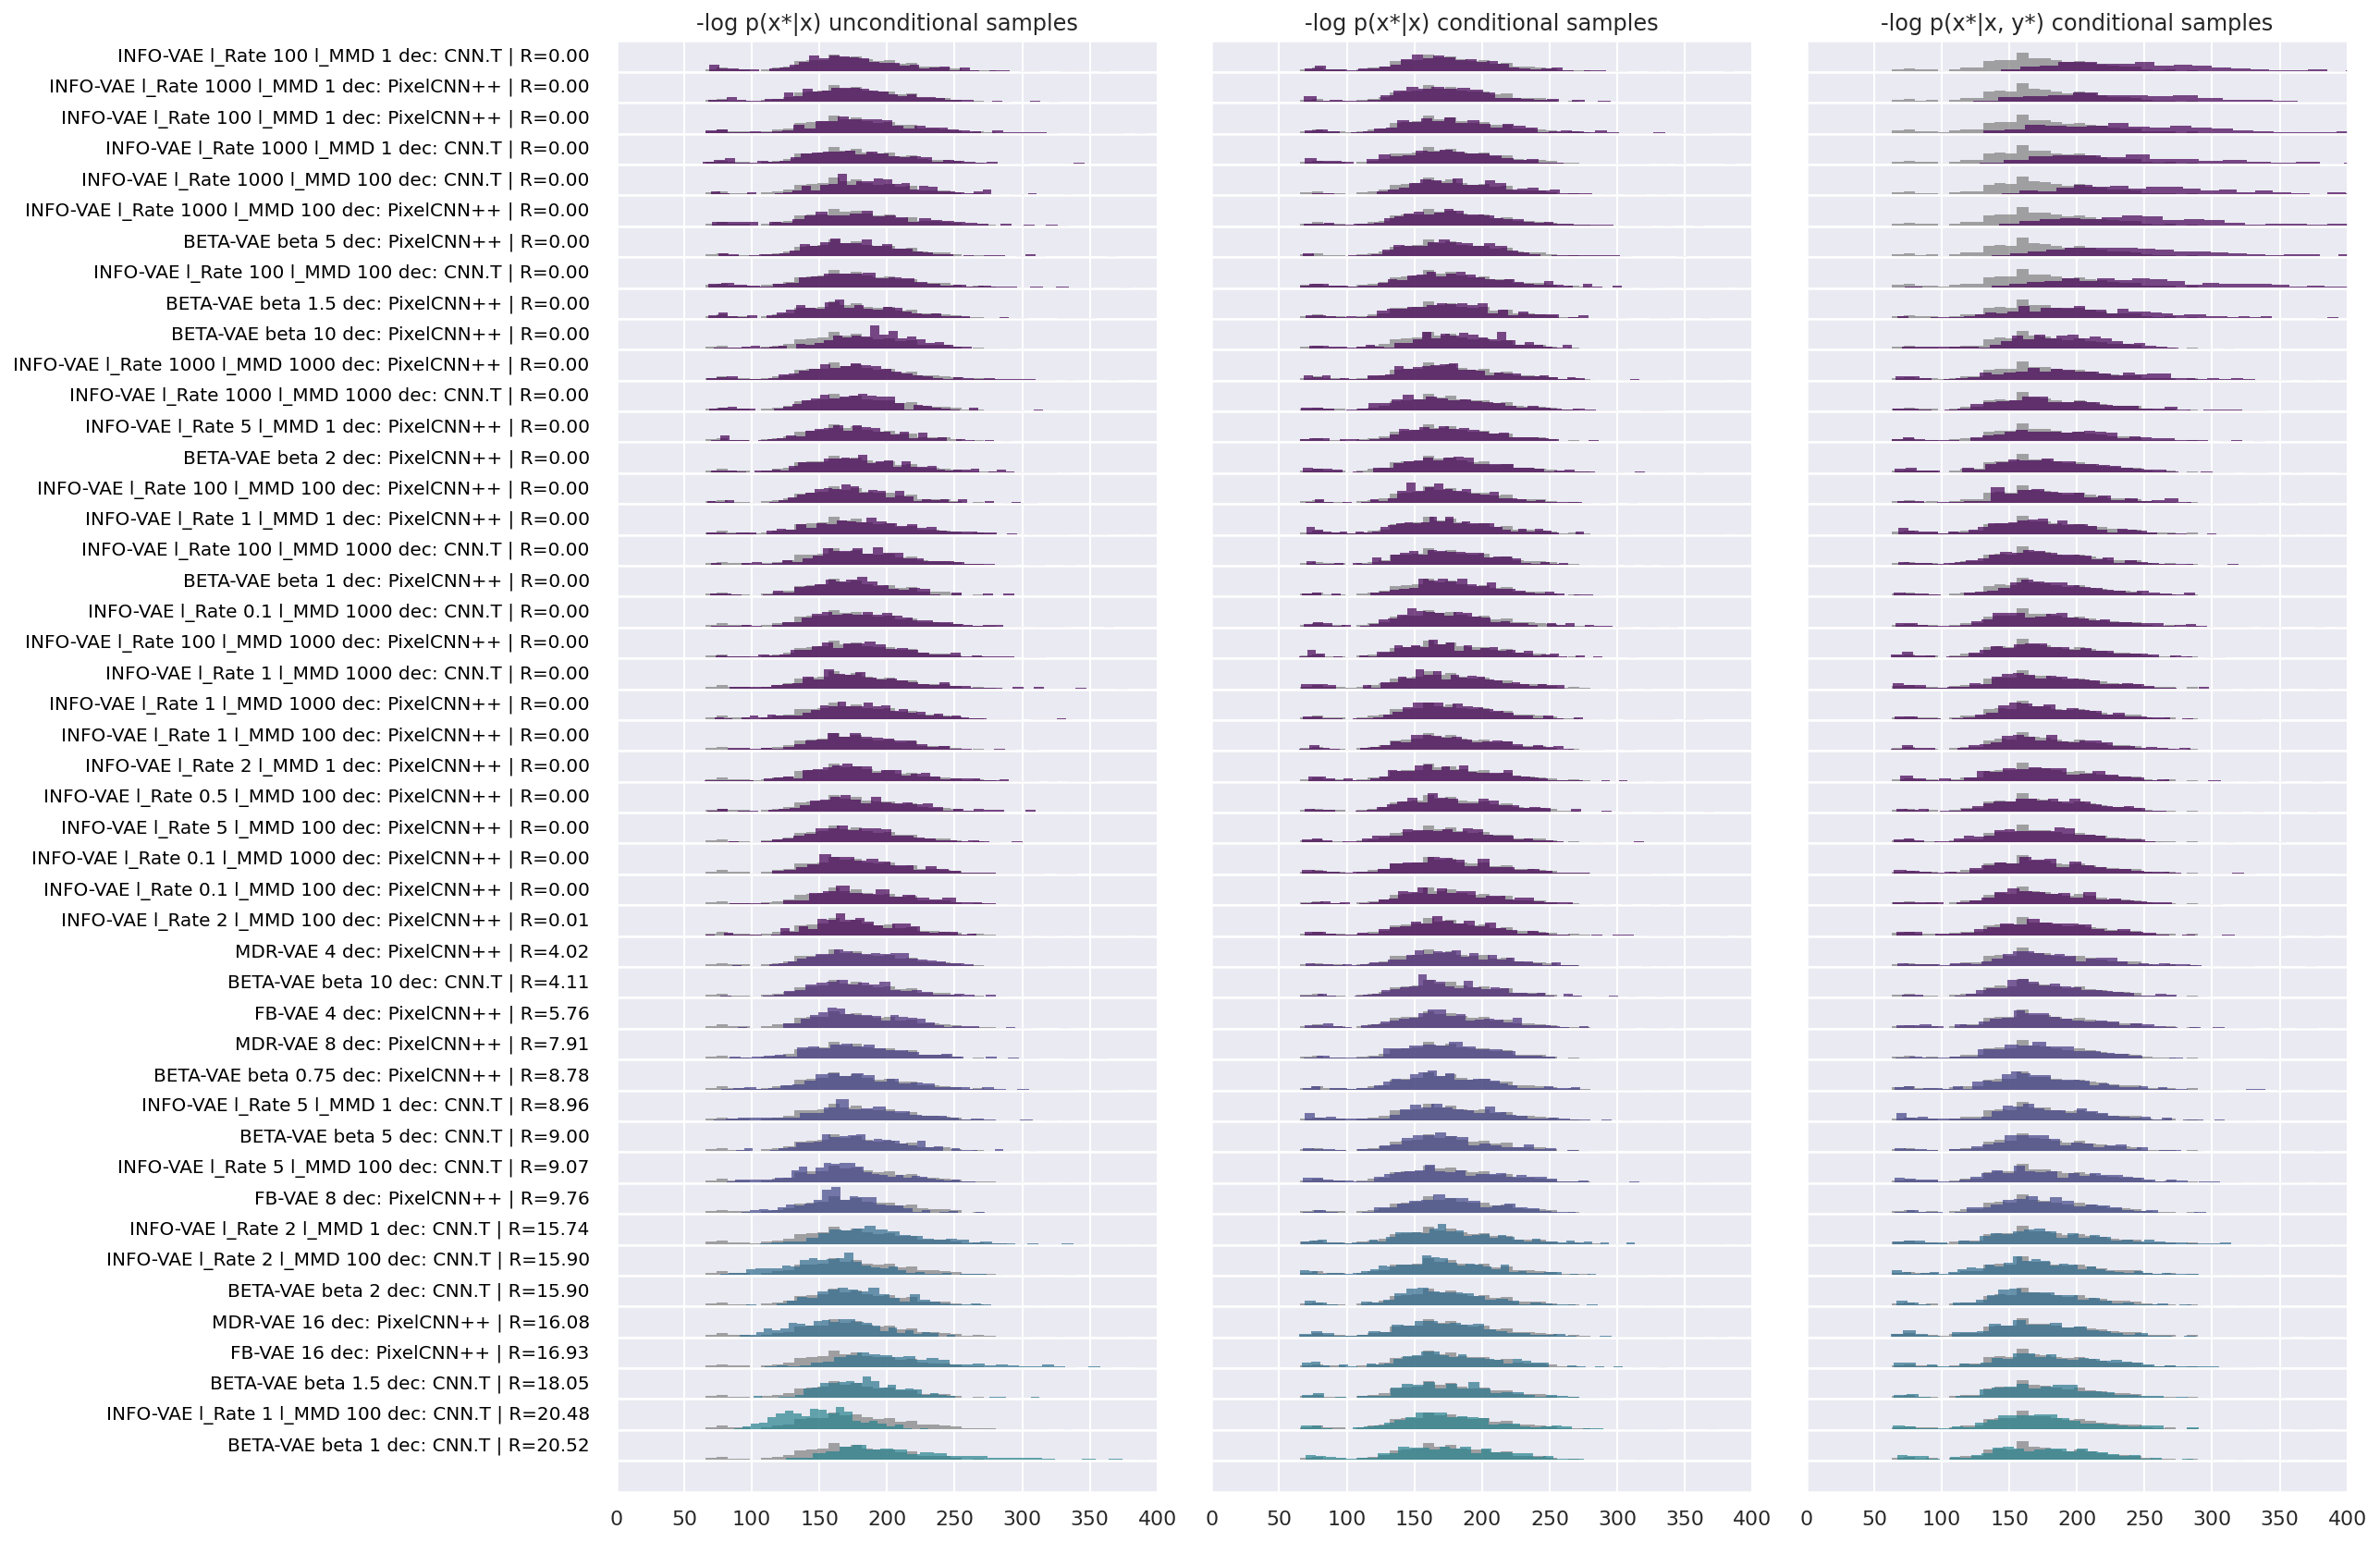

In [9]:
# ----------------------------------------------------------------------------------------------------
# sort_on, sort_name, sort_ascend = 'mmd_redo_valid', 'MMD', True                  # valid MMD
# sort_on, sort_name, sort_ascend = 'valid elbo mean', 'ELBO', True                # valid ELBO
sort_on, sort_name, sort_ascend = 'valid kl_prior_post mean', 'R', True          # valid R
# sort_on, sort_name, sort_ascend = 'valid distortion mean', 'D', True             # valid D mean
# sort_on, sort_name, sort_ascend = 'surpr_sample', 'surpr. samples', True         # LL samples
# sort_on, sort_name, sort_ascend = 'surpr_data_valid', 'surpr. data', True        # LL valid data samples
# sort_on, sort_name, sort_ascend = 'surpr_recons_valid', 'surpr. recons', True    # LL valid reconstructions

# ----------------------------------------------------------------------------------------------------
model_cols = ['unconditional_unconditional', 'unconditional_conditional', 'conditional_conditional']
model_col_names = ["-log p(x*|x) unconditional samples", "-log p(x*|x) conditional samples", "-log p(x*|x, y*) conditional samples"]

ncols = len(model_cols)
nrows = len(surprisal_values.keys())

print("Rows, cols:", ncols, nrows)
# nrows = 4

hist_kwargs = dict(lw=0, alpha=0.7, density=True, bins=40)

df_sort_on = global_stats_df.sort_values(sort_on, ascending=sort_ascend)[sort_on]
sort_on_labels, sort_on_values = df_sort_on.index, df_sort_on.values
labels = [f"{l} | {sort_name}={v:.2f}" for l, v in zip(sort_on_labels, sort_on_values)]

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*6, nrows*0.25), sharex=True, sharey=True)

minima, maxima = min(sort_on_values), max(sort_on_values)
norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)

for col, col_name in enumerate(model_cols):
    row = 0
    for idx, group_name in enumerate(sort_on_labels):
        
        #run_name = global_stats_df[global_stats_df.index == group_name].run_name.values[0]
        
        if group_name not in surprisal_values:
            continue
        
        color = mapper.to_rgba(sort_on_values[row])
        
        axs[row, col].hist(surprisal_values["data_group"][model_cols[col]], color="grey", **hist_kwargs)
        axs[row, col].hist(surprisal_values[group_name][model_cols[col]], color=color, **hist_kwargs)
        
        if col == 0:
            axs[row, col].text(-0.05, .5, labels[row], color='black', fontsize=10, ha="right", va="center", 
                               transform=axs[row, col].transAxes)
        
        axs[row, col].set_yticks([])
        axs[row, col].set_ylim([0, 0.02])
        axs[row, col].set_xlim([0, 400])
        
        if row == 0:
            axs[row, col].set_title(model_col_names[col])
        
#         if row == 3: break
            
        row += 1

plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.0)

# Analyse surprisal distribution with a DP mixture of truncated normals

In [10]:
dp_mixtures = dict()

MAX_SAMPLES_PER_GROUP = 200

NUM_COMPS = 3
NUM_CHAINS = 1
NUM_WARMUP = 100
NUM_SAMPLES = 1000

for stat_name in model_cols:
    print(stat_name)

    group_names = []
    observations = []

    for k, v in surprisal_values.items():
        group_names.append(k)
        observations.append(np.array(v[stat_name][:MAX_SAMPLES_PER_GROUP]))

    dp_mixture = DPMixture(
        group_names, 
        observations, 
        obs_dist="truncated_normal", 
        DP_alpha=1., 
        num_comps=NUM_COMPS, 
        num_samples=NUM_SAMPLES, 
        num_chains=NUM_CHAINS, 
        num_warmup=NUM_WARMUP
    )

    dp_mixture.run()

    dp_mixtures[stat_name] = dp_mixture

unconditional_unconditional


sample: 100%|██████████| 1100/1100 [01:19<00:00, 13.92it/s, 127 steps of size 7.74e-03. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
 beta[0,0]      0.77      0.04      0.77      0.71      0.84   1675.26      1.00
 beta[0,1]      0.83      0.07      0.84      0.73      0.94   1267.27      1.00
 beta[1,0]      0.63      0.04      0.63      0.56      0.69   2043.23      1.00
 beta[1,1]      0.73      0.07      0.74      0.62      0.84   1665.68      1.00
 beta[2,0]      0.29      0.04      0.29      0.22      0.36   1087.01      1.00
 beta[2,1]      0.73      0.04      0.74      0.67      0.81   1067.27      1.00
 beta[3,0]      0.34      0.04      0.34      0.28      0.42    825.37      1.01
 beta[3,1]      0.62      0.06      0.62      0.53      0.72   2501.24      1.00
 beta[4,0]      0.32      0.04      0.32      0.25      0.39    987.60      1.00
 beta[4,1]      0.65      0.05      0.65      0.57      0.73    943.05      1.00
 beta[5,0]      0.38      0.04      0.38      0.31      0.45   1435.17      1.00
 beta[5,1]      0.69      0

sample: 100%|██████████| 1100/1100 [01:51<00:00,  9.86it/s, 255 steps of size 7.09e-03. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
 beta[0,0]      0.23      0.04      0.23      0.17      0.30    754.45      1.00
 beta[0,1]      0.65      0.05      0.65      0.57      0.73   1148.48      1.00
 beta[1,0]      0.33      0.04      0.33      0.27      0.40   1827.08      1.00
 beta[1,1]      0.76      0.05      0.76      0.69      0.84    933.00      1.00
 beta[2,0]      0.29      0.04      0.29      0.21      0.35   1159.61      1.00
 beta[2,1]      0.72      0.05      0.72      0.65      0.80   1542.21      1.00
 beta[3,0]      0.25      0.04      0.25      0.18      0.32   1170.83      1.00
 beta[3,1]      0.63      0.05      0.64      0.56      0.72    966.85      1.00
 beta[4,0]      0.28      0.04      0.28      0.22      0.35   1017.61      1.00
 beta[4,1]      0.59      0.05      0.60      0.50      0.67   1149.37      1.00
 beta[5,0]      0.34      0.04      0.34      0.27      0.40   2033.72      1.00
 beta[5,1]      0.71      0

sample: 100%|██████████| 1100/1100 [01:45<00:00, 10.39it/s, 255 steps of size 6.35e-03. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
 beta[0,0]      0.47      0.04      0.47      0.40      0.53   1402.23      1.00
 beta[0,1]      0.72      0.05      0.72      0.65      0.80   1341.09      1.00
 beta[1,0]      0.57      0.04      0.57      0.51      0.64   1431.53      1.00
 beta[1,1]      0.85      0.05      0.85      0.78      0.92   1315.82      1.00
 beta[2,0]      0.52      0.04      0.52      0.45      0.59   1440.22      1.00
 beta[2,1]      0.84      0.04      0.84      0.76      0.90   1409.39      1.00
 beta[3,0]      0.48      0.04      0.48      0.41      0.55   1401.61      1.00
 beta[3,1]      0.79      0.04      0.79      0.72      0.85   1313.36      1.00
 beta[4,0]      0.46      0.04      0.46      0.39      0.52   1399.15      1.00
 beta[4,1]      0.80      0.04      0.80      0.73      0.86   1352.14      1.00
 beta[5,0]      0.53      0.04      0.53      0.47      0.59   1491.58      1.00
 beta[5,1]      0.91      0

# Plot the DP Mixture fits on surprisal values

UNCONDITIONAL_UNCONDITIONAL


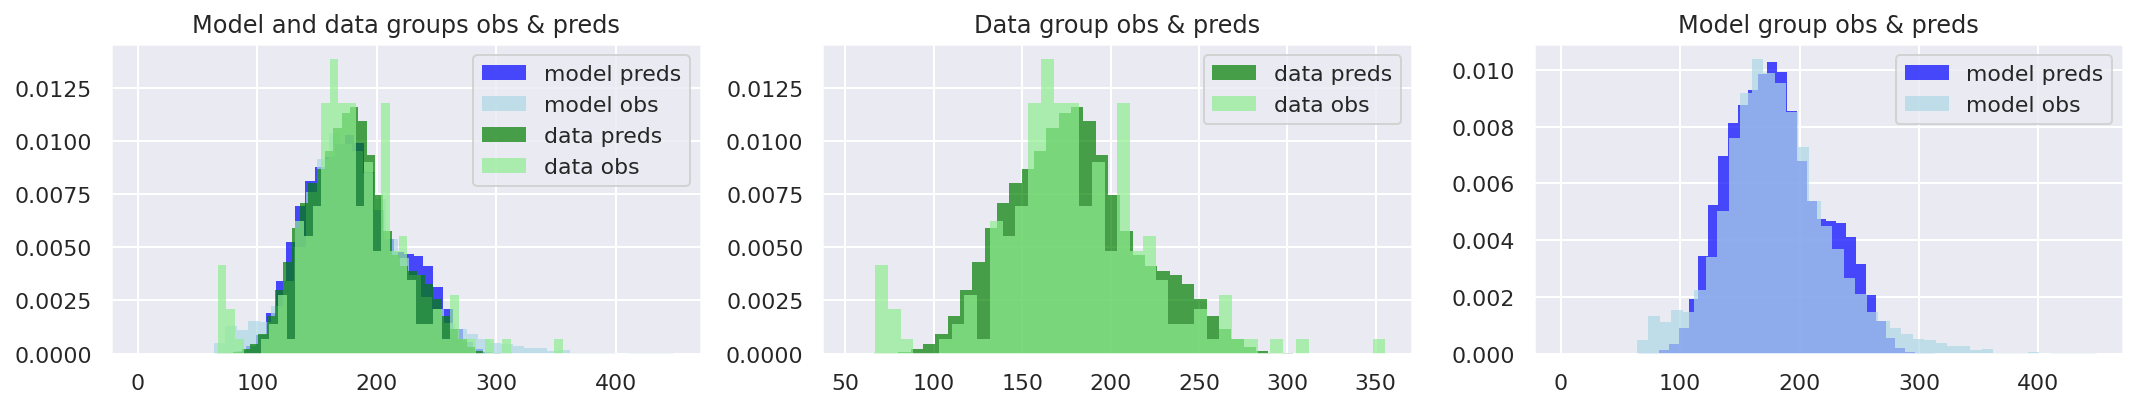

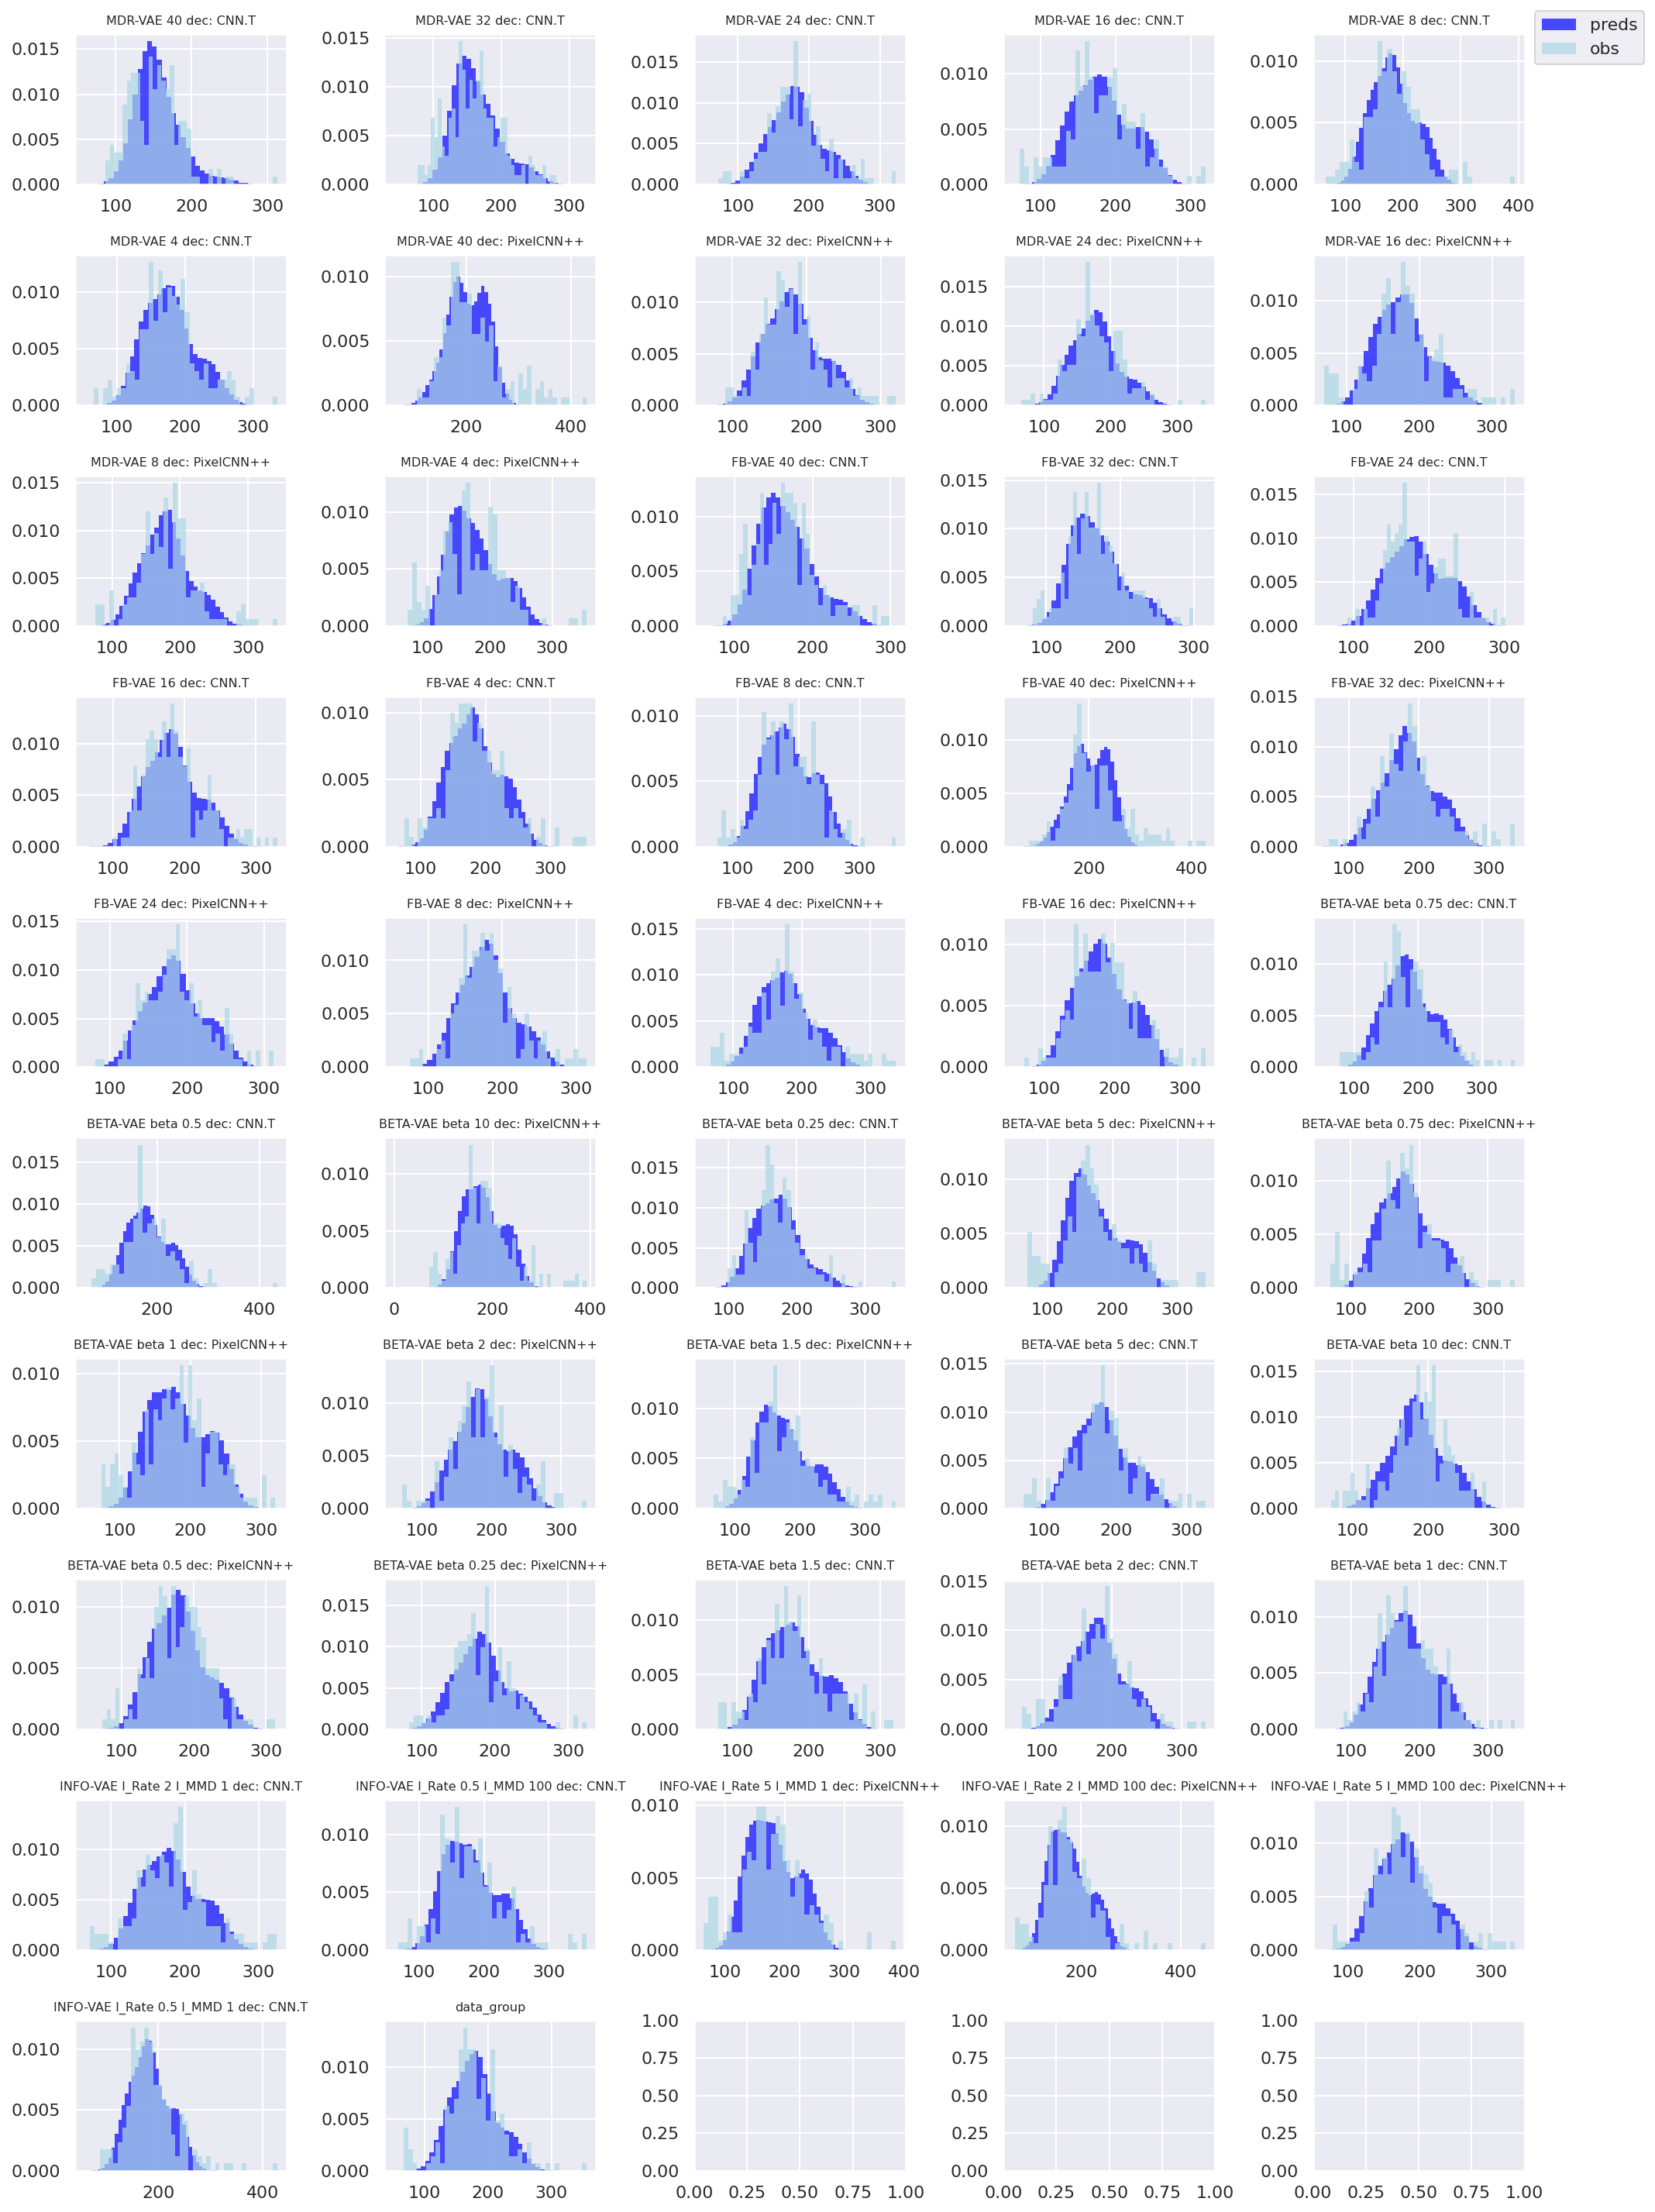

UNCONDITIONAL_CONDITIONAL


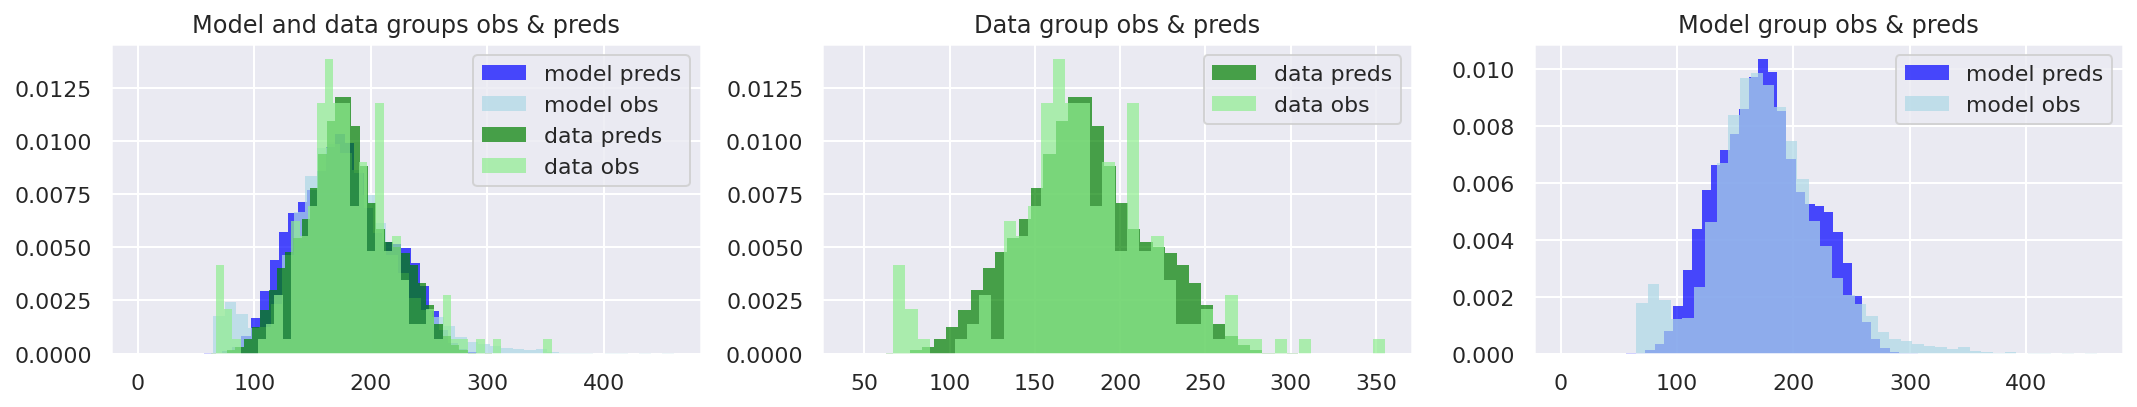

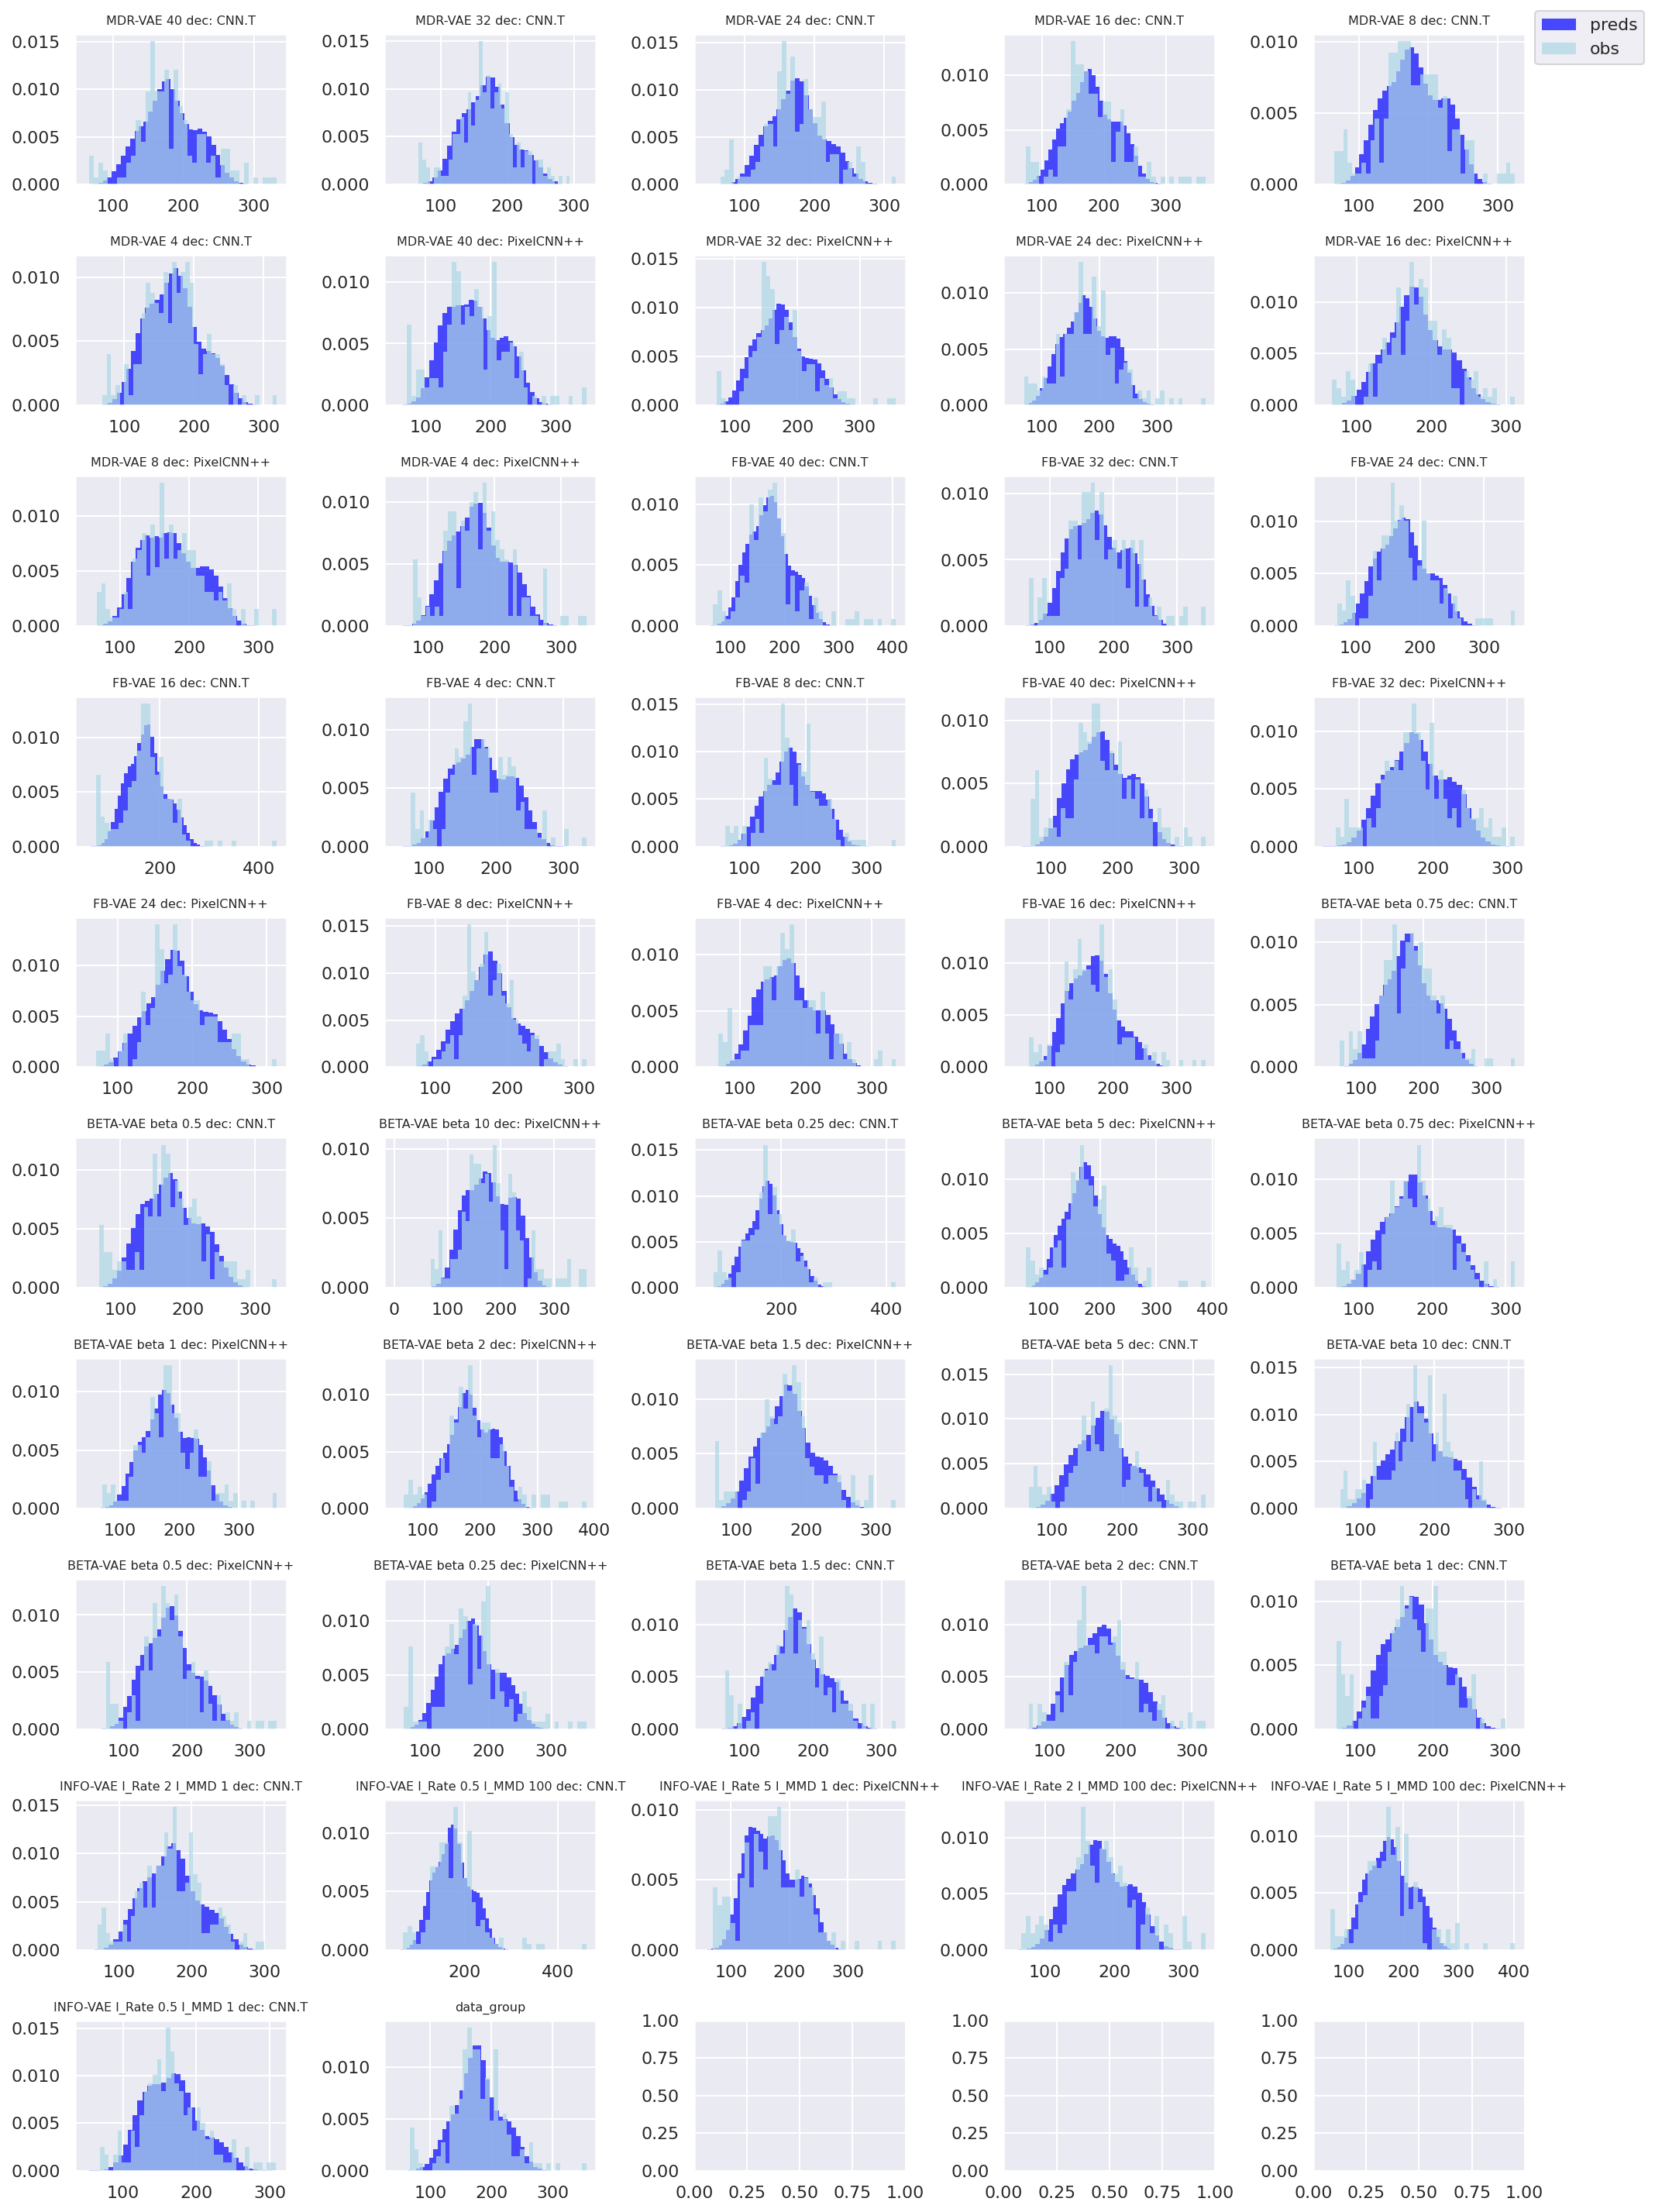

CONDITIONAL_CONDITIONAL


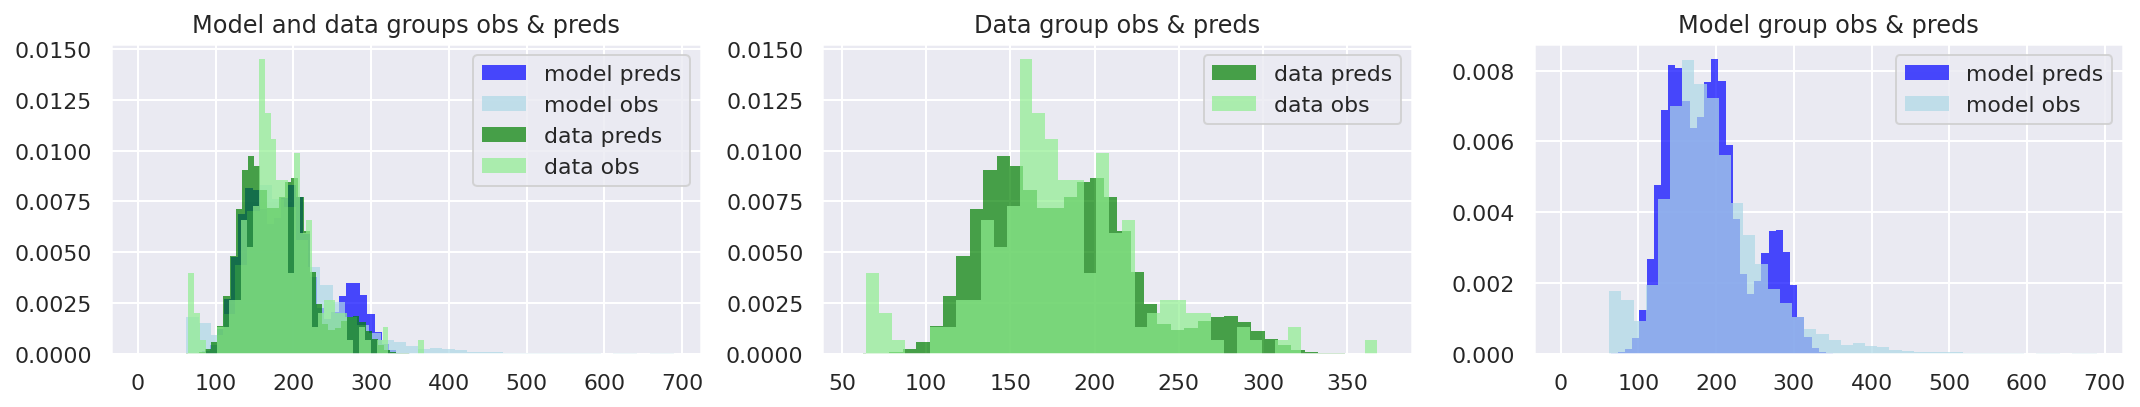

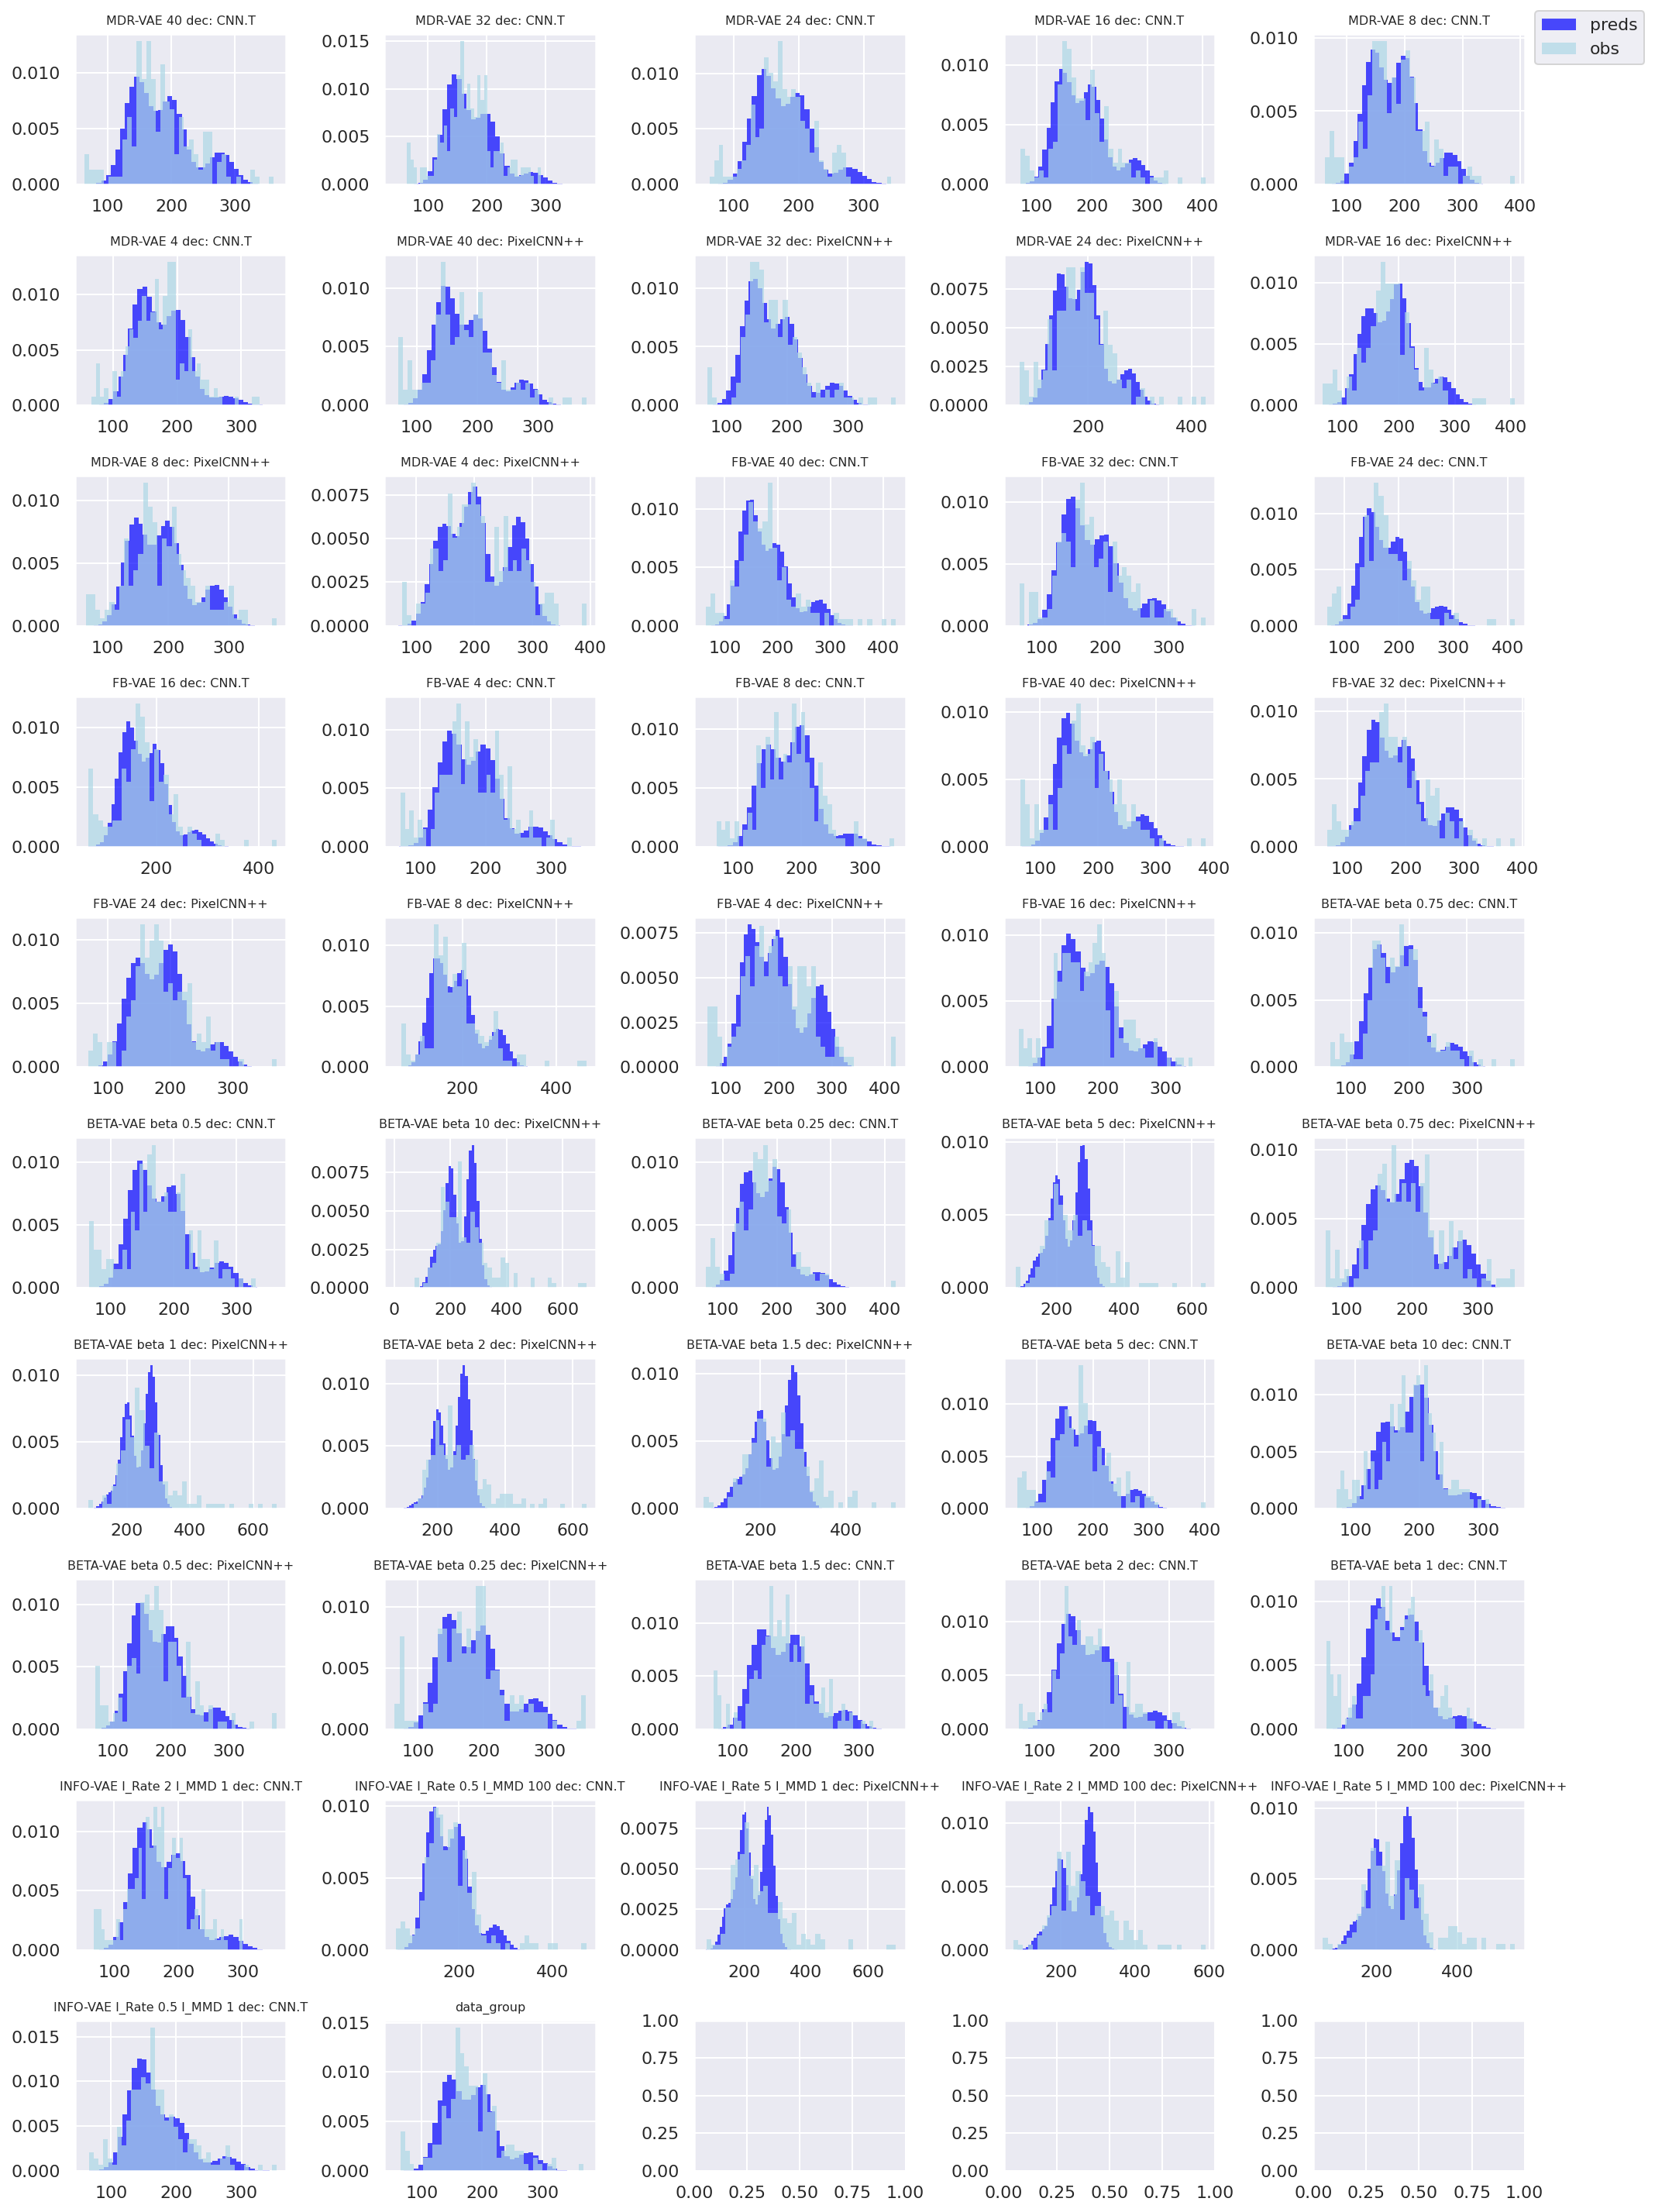

In [11]:
for stat, dp_mixture in dp_mixtures.items():
    print(stat.upper())

    plot_model_data_preds_obs(dp_mixture)
    plot_all_groups_preds_obs(dp_mixture)

# Now assess "divergence" from model sample surprisal values from data group in three ways:

1. KL between component assignments under the DP Mixture
2. Difference between estimated densities under the DP Mixture
3. Wasserstein distance between surprisal value histograms (no DP Mixture used)

In [12]:
all_df = compute_all_divergences_data_model_groups(dp_mixtures, surprisal_values)

UNCONDITIONAL_UNCONDITIONAL
UNCONDITIONAL_CONDITIONAL
CONDITIONAL_CONDITIONAL


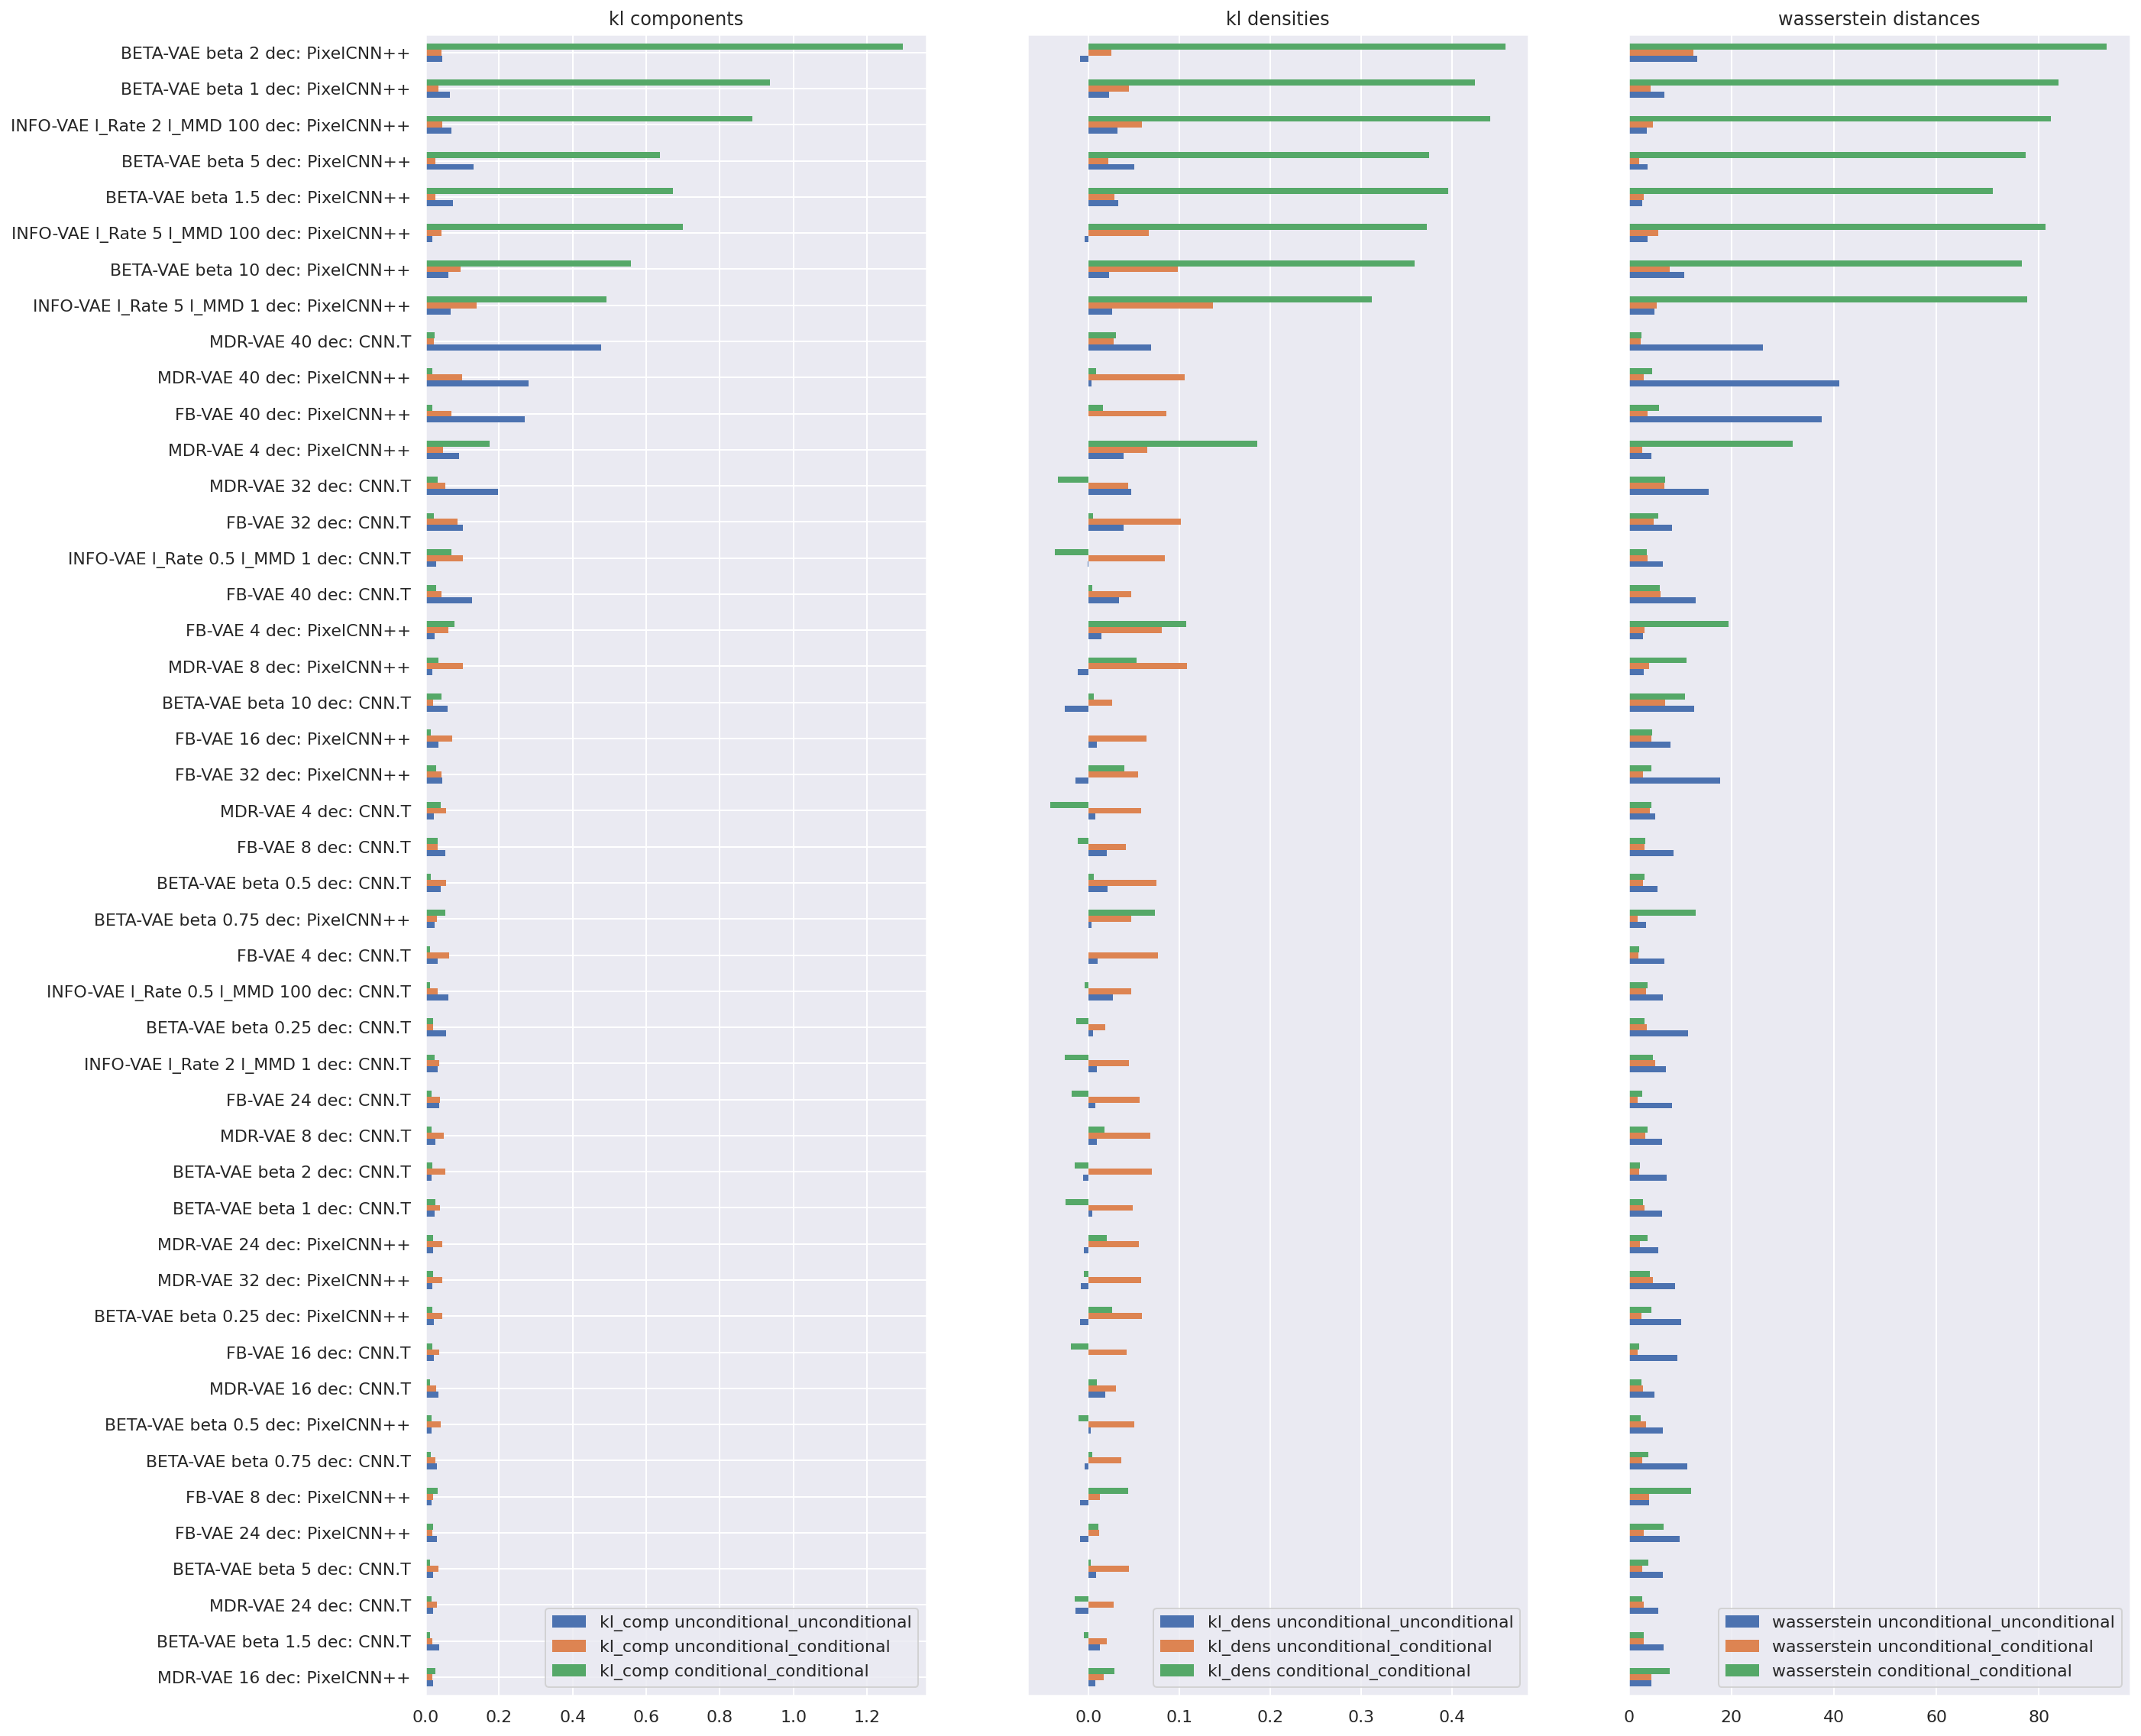

In [13]:
SORT_ON = "kl_comp sum"
plot_divergences_data_model_groups(all_df, sort_on=SORT_ON, plot_only=None)

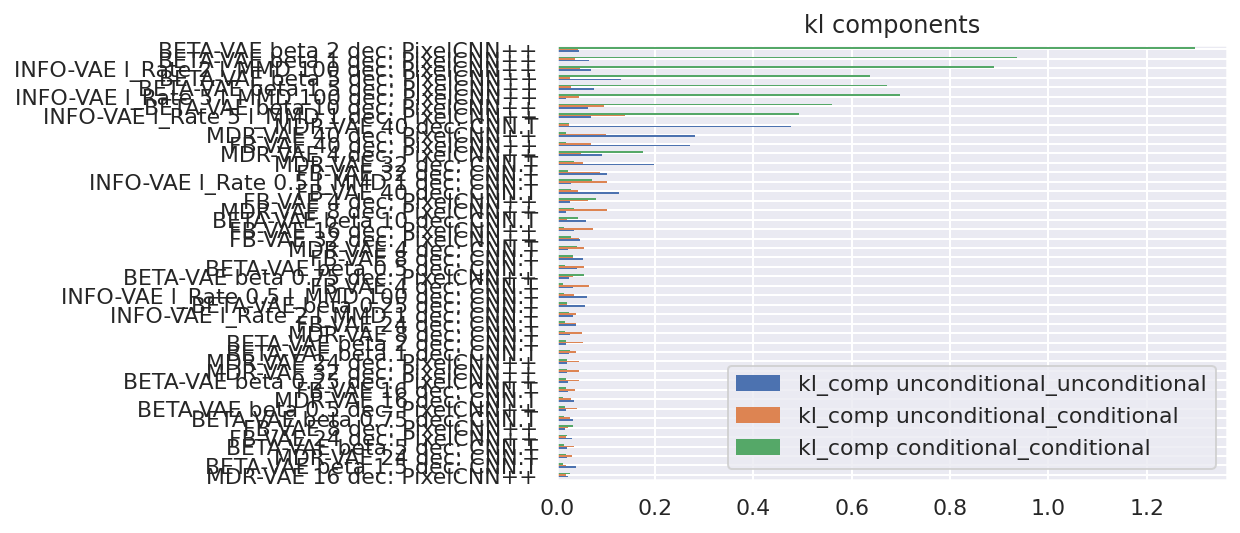

In [14]:
plot_divergences_data_model_groups(all_df, sort_on=SORT_ON, plot_only="kl_comp")